In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,51712,None,None,85791.535491
2020-06-13,51713,None,None,79682.840416
2020-06-14,51714,None,None,74017.446807
2020-06-15,51715,None,None,68679.970903
2020-06-16,51716,None,None,63923.400184
...,...,...,...,...
2021-04-24,52028,None,None,20469.356276
2021-04-25,52029,None,None,19722.716266
2021-04-26,52030,None,None,19072.169196


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-28_2021-04-28-19-58.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-27_2021-04-27-17-12.pickle


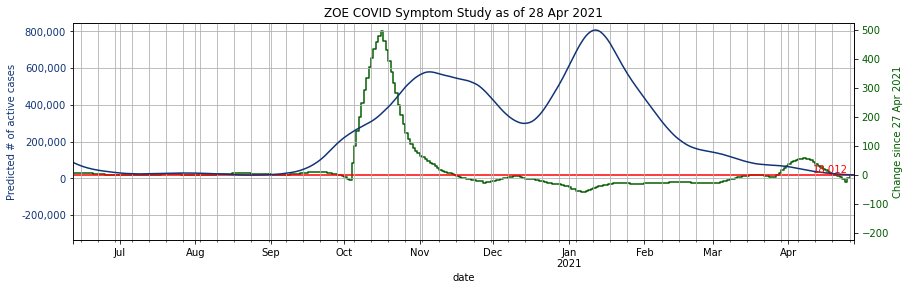

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

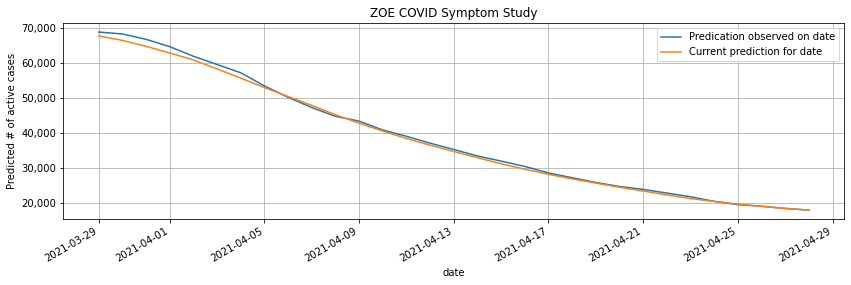

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-28_2021-04-28-19-58.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
373,North Ayrshire,S12000021,0.696905
302,Kirklees,E08000034,0.301269
25,Rutland,E06000017,0.301180
248,Rugby,E07000220,0.276248
240,Wakefield,E08000036,0.216321
91,Eden,E07000030,0.162490
276,Liverpool,E08000012,0.141888
155,Dover,E07000108,0.136788
347,Hammersmith and Fulham,E09000013,0.132726
339,Swansea,W06000011,0.109038
